In [173]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = None

In [2]:
# import zipfile
# with zipfile.ZipFile('track_1.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [3]:
# Путь к директории с данными

# data_dir = '/home/common/emergency_datahack/data_processed/track_1_package/track_1/'
data_dir = 'data'
os.listdir(data_dir)

['meteo_coord.csv',
 'reference_horiz_visib.csv',
 'reference_water_codes.csv',
 'test.csv',
 'train.csv',
 'hydro_1day.csv',
 'hydro_coord.csv',
 'ice_saw.csv',
 'meteo_1day.csv',
 'meteo_1month.csv']

In [4]:
# Загрузим всё
main_df = pd.read_csv(data_dir + '/train.csv')

# Метео
mc = pd.read_csv(data_dir + '/meteo_coord.csv')
mld = pd.read_csv(data_dir + '/meteo_1day.csv')
mlm = pd.read_csv(data_dir + '/meteo_1month.csv')
rhv = pd.read_csv(data_dir + '/reference_horiz_visib.csv')

# Гидро
hc = pd.read_csv(data_dir + '/hydro_coord.csv')
hld = pd.read_csv(data_dir + '/hydro_1day.csv',
                   parse_dates=['date'])
rwc = pd.read_csv(data_dir + '/reference_water_codes.csv')

In [5]:
main_df.head(1)

year  station_id  day  ice_jam
0  2000        3019    1      0.0

In [6]:
main_df.shape

(11277, 4)

In [7]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)

hc = merge_coord(hc)
mc = merge_coord(mc)
hc['closest_hydro'] = mc.lat_long.apply(lambda x: stat_km(x, mc))

In [8]:
mld = mld.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mld.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mld.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [9]:
mld.shape

(237776, 46)

### Разделим годы на train и test сбалансированно по суммарной продолжительности заторных событий

In [10]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    26.000000
mean      5.307692
std       3.792300
min       0.000000
25%       3.000000
50%       5.000000
75%       8.000000
max      16.000000
Name: ice_jam, dtype: float64

In [11]:
jams_by_year.shape

(26, 2)

In [12]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    9
(3, 5]     7
(5, 8]     6
(8, 16]    4
Name: ice_jam_bins, dtype: int64

In [13]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18, 2) (8, 2) (18,) (8,)


### Соберем фичи из гидроданных

In [15]:
main_df.head(1)

year  station_id  day  ice_jam
0  2000        3019    1      0.0

In [16]:
hc.head(1)

station_id              name    lat     lon  distance_from_source  \
0        3019  КИРЕНСК - Р.ЛЕНА  57.77  108.07                1140.0   

   drainage_area  z_null         lat_long  closest_hydro  
0          92200  249.38  (57.77, 108.07)          24538

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [17]:
# Внесем не темпоральные данные
main_df = pd.merge(main_df, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

# Возьмем также данные из ежедневных наблюдений
hld = pd.read_csv(data_dir + '/hydro_1day.csv',
                   parse_dates=['date'])
hld.head(1)

year  station_id  month  day       date  stage_avg  stage_min  stage_max  \
0  2000        3019      1    1 2000-01-01       74.0       74.0       74.0   

   temp water_code  ice_thickness  snow_height  place  discharge  
0   NaN         46            NaN          NaN    NaN        NaN

In [18]:
main_df.head(1)

year  station_id  day  ice_jam  distance_from_source  drainage_area  z_null
0  2000        3019    1      0.0                1140.0          92200  249.38

In [19]:
main_df.shape

(11277, 7)

In [20]:
hld['station_id'] = hld.station_id.astype(int)
mld['station_id'] = mld['station_id'].astype(int)

In [21]:
hld.head()

year  station_id  month  day       date  stage_avg  stage_min  stage_max  \
0  2000        3019      1    1 2000-01-01       74.0       74.0       74.0   
1  2000        3019      1    2 2000-01-02       70.0       70.0       70.0   
2  2000        3019      1    3 2000-01-03       67.0       67.0       67.0   
3  2000        3019      1    4 2000-01-04       64.0       64.0       64.0   
4  2000        3019      1    5 2000-01-05       60.0       60.0       60.0   

   temp water_code  ice_thickness  snow_height  place  discharge  
0   NaN         46            NaN          NaN    NaN        NaN  
1   NaN         46            NaN          NaN    NaN        NaN  
2   NaN         46            NaN          NaN    NaN        NaN  
3   NaN         46            NaN          NaN    NaN        NaN  
4   NaN         46            NaN          NaN    NaN        NaN

In [22]:
mld.head()

year  month  day  route_type  snow_coverage_near_station  \
0  1985      1    1         NaN                         NaN   
1  1985      1    2         NaN                         NaN   
2  1985      1    3         NaN                         NaN   
3  1985      1    4         NaN                         NaN   
4  1985      1    5         NaN                         NaN   

   snow_coverage_route  ice_crust_route  snow_height_aver  snow_height_max  \
0                  NaN              NaN               NaN              NaN   
1                  NaN              NaN               NaN              NaN   
2                  NaN              NaN               NaN              NaN   
3                  NaN              NaN               NaN              NaN   
4                  NaN              NaN               NaN              NaN   

   snow_height_min  snow_density_aver  ice_crust_aver  \
0              NaN                NaN             NaN   
1              NaN                NaN             NaN   
2              NaN                NaN             NaN   
3              NaN                NaN             NaN   
4              NaN                NaN             NaN   

   snow_saturated_thickness  water_thickness  water_in_snow  water_total  \
0                       NaN              NaN            NaN          NaN   
1                       NaN              NaN            NaN          NaN   
2                       NaN              NaN            NaN          NaN   
3                       NaN              NaN            NaN          NaN   
4                       NaN              NaN            NaN          NaN   

   snow_coverage_charact  snow_charact  snow_height  snow_coverage_station  \
0                    NaN           NaN         32.0                   10.0   
1                    NaN           NaN         32.0                   10.0   
2                    NaN           NaN         32.0                   10.0   
3                    NaN           NaN         32.0                   10.0   
4                    NaN           NaN         32.0                   10.0   

   snow_height_q1  snow_height_q2  snow_height_q3  temperature_20cm  \
0             0.0             0.0             0.0               NaN   
1             0.0             0.0             0.0               NaN   
2             0.0             0.0             0.0               NaN   
3             0.0             0.0             0.0               NaN   
4             0.0             0.0             0.0               NaN   

   temperature_20cm_qual  temperature_40cm  temperature_40cm_qual  \
0                    NaN               NaN                    NaN   
1                    NaN               NaN                    NaN   
2                    NaN               NaN                    NaN   
3                    NaN               NaN                    NaN   
4                    NaN               NaN                    NaN   

   temperature_80cm  temperature_80cm_qual  temperature_120cm  \
0               NaN                    NaN                NaN   
1               NaN                    NaN                NaN   
2               NaN                    NaN                NaN   
3               NaN                    NaN                NaN   
4               NaN                    NaN                NaN   

   temperature_120cm_qual  temperature_160cm  temperature_160cm_qual  \
0                     NaN                NaN                     NaN   
1                     NaN                NaN                     NaN   
2                     NaN                NaN                     NaN   
3                     NaN                NaN                     NaN   
4                     NaN                NaN                     NaN   

   temperature_240cm  temperature_240cm_qual  temperature_320cm  \
0                NaN                     NaN                NaN   
1                NaN                     NaN                NaN   
2                Na

In [23]:
hld.shape

(224848, 14)

In [24]:
mld.shape

(237776, 46)

In [25]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
hld = hld.fillna(0)
hld.head()

year  station_id  month  day       date  stage_avg  stage_min  stage_max  \
0  2000        3019      1    1 2000-01-01       74.0       74.0       74.0   
1  2000        3019      1    2 2000-01-02       70.0       70.0       70.0   
2  2000        3019      1    3 2000-01-03       67.0       67.0       67.0   
3  2000        3019      1    4 2000-01-04       64.0       64.0       64.0   
4  2000        3019      1    5 2000-01-05       60.0       60.0       60.0   

   temp water_code  ice_thickness  snow_height_x  place  discharge  \
0   0.0         46            0.0            0.0    0.0        0.0   
1   0.0         46            0.0            0.0    0.0        0.0   
2   0.0         46            0.0            0.0    0.0        0.0   
3   0.0         46            0.0            0.0    0.0        0.0   
4   0.0         46            0.0            0.0    0.0        0.0   

   route_type  snow_coverage_near_station  snow_coverage_route  \
0         0.0                         0.0                  0.0   
1         0.0                         0.0                  0.0   
2         0.0                         0.0                  0.0   
3         0.0                         0.0                  0.0   
4         0.0                         0.0                  0.0   

   ice_crust_route  snow_height_aver  snow_height_max  snow_height_min  \
0              0.0               0.0              0.0              0.0   
1              0.0               0.0              0.0              0.0   
2              0.0               0.0              0.0              0.0   
3              0.0               0.0              0.0              0.0   
4              0.0               0.0              0.0              0.0   

   snow_density_aver  ice_crust_aver  snow_saturated_thickness  \
0                0.0             0.0                       0.0   
1                0.0             0.0                       0.0   
2                0.0             0.0                       0.0   
3                0.0             0.0                       0.0   
4                0.0             0.0                       0.0   

   water_thickness  water_in_snow  water_total  snow_coverage_charact  \
0              0.0            0.0          0.0                    0.0   
1              0.0            0.0          0.0                    0.0   
2              0.0            0.0          0.0                    0.0   
3              0.0            0.0          0.0                    0.0   
4              0.0            0.0          0.0                    0.0   

   snow_charact  snow_height_y  snow_coverage_station  snow_height_q1  \
0           0.0           44.0                   10.0             0.0   
1           0.0           44.0                   10.0             0.0   
2           0.0           45.0                   10.0             0.0   
3           0.0           45.0                   10.0             0.0   
4           0.0           46.0                   10.0             0.0   

   snow_height_q2  snow_height_q3  temperature_20cm  temperature_20cm_qual  \
0             0.0             0.0               0.0                    0.0   
1             0.0             0.0               0.0                    0.0   
2             0.0             0.0               0.0                    0.0   
3             0.0             0.0               0.0                    0.0   
4             0.0             0.0               0.0                    0.0   

   temperature_40cm  temperature_40cm_qual  temperature_80cm  \
0               0.0                    0.0               0.0   
1               0.0                    0.0               0.0   
2               0.0                    0.0               0.0   
3               0.0                    0.0               0.0   
4               0.0                    0.0               0.0   

   temperature_80cm_qual  temperature_120cm  temperature_120cm_qual  \
0                    0.0                0.0                     0

In [26]:
hld.shape

(220433, 56)

### Скорректируем год, в который доступно наблюдение

In [27]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year
    
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [28]:
hld.head(1)

station_id  month  stage_avg  stage_min  stage_max  temp water_code  \
0        3019      1       74.0       74.0       74.0   0.0         46   

   ice_thickness  snow_height_x  place  discharge  route_type  \
0            0.0            0.0    0.0        0.0         0.0   

   snow_coverage_near_station  snow_coverage_route  ice_crust_route  \
0                         0.0                  0.0              0.0   

   snow_height_aver  snow_height_max  snow_height_min  snow_density_aver  \
0               0.0              0.0              0.0                0.0   

   ice_crust_aver  snow_saturated_thickness  water_thickness  water_in_snow  \
0             0.0                       0.0              0.0            0.0   

   water_total  snow_coverage_charact  snow_charact  snow_height_y  \
0          0.0                    0.0           0.0           44.0   

   snow_coverage_station  snow_height_q1  snow_height_q2  snow_height_q3  \
0                   10.0             0.0             0.0             0.0   

   temperature_20cm  temperature_20cm_qual  temperature_40cm  \
0               0.0                    0.0               0.0   

   temperature_40cm_qual  temperature_80cm  temperature_80cm_qual  \
0                    0.0               0.0                    0.0   

   temperature_120cm  temperature_120cm_qual  temperature_160cm  \
0                0.0                     0.0                0.0   

   temperature_160cm_qual  temperature_240cm  temperature_240cm_qual  \
0                     0.0                0.0                     0.0   

   temperature_320cm  temperature_320cm_qual  temperature_ks_5cm  \
0                0.0                     0.0                 0.0   

   temperature_ks_5cm_qual  temperature_ks_10cm  temperature_ks_10cm_qual  \
0                      0.0                  0.0                       0.0   

   temperature_ks_15cm  temperature_ks_15cm_qual  temperature_ks_20cm  \
0                  0.0                       0.0                  0.0   

   temperature_ks_20cm_qual  target_year  
0                       0.0         2000

In [29]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']

hld_mean = hld.groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.groupby(index).std().add_prefix('std_').reset_index()
data_frames = [hld_mean, hld_max, hld_min, hld_std]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

station_id  month  target_year  mean_stage_avg  mean_stage_min  \
0        3019      1         1985      -25.709677      -25.709677   
1        3019      1         1986       56.322581       56.000000   
2        3019      1         1987        9.032258        8.516129   
3        3019      1         1988       28.806452       28.516129   
4        3019      1         1989       82.741935       82.225806   

   mean_stage_max  mean_temp  mean_ice_thickness  mean_snow_height_x  \
0      -25.580645        0.0           10.612903            6.709677   
1       56.451613        0.0            8.516129            5.774194   
2        9.161290        0.0            9.322581            3.580645   
3       28.806452        0.0            9.096774            5.290323   
4       82.774194        0.0            9.225806            7.774194   

   mean_place  mean_discharge  mean_route_type  \
0    0.193548             0.0              0.0   
1    0.193548             0.0              0.0   
2    0.193548             0.0              0.0   
3    0.193548             0.0              0.0   
4    0.193548             0.0              0.0   

   mean_snow_coverage_near_station  mean_snow_coverage_route  \
0                              0.0                       0.0   
1                              0.0                       0.0   
2                              0.0                       0.0   
3                              0.0                       0.0   
4                              0.0                       0.0   

   mean_ice_crust_route  mean_snow_height_aver  mean_snow_height_max  \
0                   0.0                    0.0                   0.0   
1                   0.0                    0.0                   0.0   
2                   0.0                    0.0                   0.0   
3                   0.0                    0.0                   0.0   
4                   0.0                    0.0                   0.0   

   mean_snow_height_min  mean_snow_density_aver  mean_ice_crust_aver  \
0                   0.0                     0.0                  0.0   
1                   0.0                     0.0                  0.0   
2                   0.0                     0.0                  0.0   
3                   0.0                     0.0                  0.0   
4                   0.0                     0.0                  0.0   

   mean_snow_saturated_thickness  mean_water_thickness  mean_water_in_snow  \
0                            0.0                   0.0                 0.0   
1                            0.0                   0.0                 0.0   
2                            0.0                   0.0                 0.0   
3                            0.0                   0.0                 0.0   
4                            0.0                   0.0                 0.0   

   mean_water_total  mean_snow_coverage_charact  mean_snow_charact  \
0               0.0                         0.0                0.0   
1               0.0                         0.0                0.0   
2               0.0                         0.0                0.0   
3               0.0                         0.0                0.0   
4               0.0                         0.0                0.0   

   mean_snow_height_y  mean_snow_coverage_station  mean_snow_height_q1  \
0           33.064516                        10.0                  0.0   
1           32.129032                        10.0                  0.0   
2           25.419355                        10.0                  0.0   
3           37.322581                        10.0                  0.0   
4           35.225806                        10.0                  0.0   

   mean_snow_height_q2  mean_snow_height_q3  mean_temperature_20cm  \
0                  0.0                  0.0                    0.0   
1                  0.0                  0.0                    0.0   
2                  0.0                  0.0               

In [30]:
hydro_monthly.shape

(7750, 203)

In [31]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features

station_id  target_year  1_mean_stage_min  1_mean_stage_max  1_mean_temp  \
0          3019         1985        -25.709677        -25.580645          0.0   
1          3019         1986         56.000000         56.451613          0.0   
2          3019         1987          8.516129          9.161290          0.0   
3          3019         1988         28.516129         28.806452          0.0   
4          3019         1989         82.225806         82.774194          0.0   
..          ...          ...               ...               ...          ...   
915        3555         2016        248.225806        248.225806          0.0   
916        3555         2017        282.000000        282.000000          0.0   
917        3555         2018        251.354839        251.354839          0.0   
918        3555         2019        270.967742        270.967742          0.0   
919        3555         2020               NaN               NaN          NaN   

     1_mean_ice_thickness  1_mean_snow_height_x  1_mean_place  \
0               10.612903              6.709677      0.193548   
1                8.516129              5.774194      0.193548   
2                9.322581              3.580645      0.193548   
3                9.096774              5.290323      0.193548   
4                9.225806              7.774194      0.193548   
..                    ...                   ...           ...   
915              5.709677              4.548387      0.193548   
916              4.580645              3.806452      0.193548   
917              3.967742              3.806452      0.096774   
918              3.612903              2.419355      0.096774   
919                   NaN                   NaN           NaN   

     1_mean_discharge  1_mean_route_type  1_mean_snow_coverage_near_station  \
0                 0.0           0.000000                                0.0   
1                 0.0           0.000000                                0.0   
2                 0.0           0.000000                                0.0   
3                 0.0           0.000000                                0.0   
4                 0.0           0.000000                                0.0   
..                ...                ...                                ...   
915               0.0           0.193548                                0.0   
916               0.0           0.193548                                0.0   
917               0.0           0.193548                                0.0   
918               0.0           0.193548                                0.0   
919               NaN                NaN                                NaN   

     1_mean_snow_coverage_route  1_mean_ice_crust_route  \
0                      0.000000                     0.0   
1                      0.000000                     0.0   
2                      0.000000                     0.0   
3                      0.000000                     0.0   
4                      0.000000                     0.0   
..                          ...                     ...   
915                    0.967742                     0.0   
916                    0.967742                     0.0   
917                    0.967742                     0.0   
918                    0.967742                     0.0   
919                         NaN                     NaN   

     1_mean_snow_height_aver  1_mean_snow_height_max  1_mean_snow_height_min  \
0                   0.000000                0.000000                0.000000   
1                   0.000000                0.000000                0.000000   
2                   0.000000                0.000000                0.000000   
3                   0.000000                0.000000                0.000000   
4                   0.000000                0.000000                0.000000   
..                       ...                     ...                     ...   
915                 3.741935     

In [32]:
hydro_features.shape

(920, 1793)

In [33]:
hydro_features

station_id  target_year  1_mean_stage_min  1_mean_stage_max  1_mean_temp  \
0          3019         1985        -25.709677        -25.580645          0.0   
1          3019         1986         56.000000         56.451613          0.0   
2          3019         1987          8.516129          9.161290          0.0   
3          3019         1988         28.516129         28.806452          0.0   
4          3019         1989         82.225806         82.774194          0.0   
..          ...          ...               ...               ...          ...   
915        3555         2016        248.225806        248.225806          0.0   
916        3555         2017        282.000000        282.000000          0.0   
917        3555         2018        251.354839        251.354839          0.0   
918        3555         2019        270.967742        270.967742          0.0   
919        3555         2020               NaN               NaN          NaN   

     1_mean_ice_thickness  1_mean_snow_height_x  1_mean_place  \
0               10.612903              6.709677      0.193548   
1                8.516129              5.774194      0.193548   
2                9.322581              3.580645      0.193548   
3                9.096774              5.290323      0.193548   
4                9.225806              7.774194      0.193548   
..                    ...                   ...           ...   
915              5.709677              4.548387      0.193548   
916              4.580645              3.806452      0.193548   
917              3.967742              3.806452      0.096774   
918              3.612903              2.419355      0.096774   
919                   NaN                   NaN           NaN   

     1_mean_discharge  1_mean_route_type  1_mean_snow_coverage_near_station  \
0                 0.0           0.000000                                0.0   
1                 0.0           0.000000                                0.0   
2                 0.0           0.000000                                0.0   
3                 0.0           0.000000                                0.0   
4                 0.0           0.000000                                0.0   
..                ...                ...                                ...   
915               0.0           0.193548                                0.0   
916               0.0           0.193548                                0.0   
917               0.0           0.193548                                0.0   
918               0.0           0.193548                                0.0   
919               NaN                NaN                                NaN   

     1_mean_snow_coverage_route  1_mean_ice_crust_route  \
0                      0.000000                     0.0   
1                      0.000000                     0.0   
2                      0.000000                     0.0   
3                      0.000000                     0.0   
4                      0.000000                     0.0   
..                          ...                     ...   
915                    0.967742                     0.0   
916                    0.967742                     0.0   
917                    0.967742                     0.0   
918                    0.967742                     0.0   
919                         NaN                     NaN   

     1_mean_snow_height_aver  1_mean_snow_height_max  1_mean_snow_height_min  \
0                   0.000000                0.000000                0.000000   
1                   0.000000                0.000000                0.000000   
2                   0.000000                0.000000                0.000000   
3                   0.000000                0.000000                0.000000   
4                   0.000000                0.000000                0.000000   
..                       ...                     ...                     ...   
915                 3.741935     

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [34]:
main_df

year  station_id  day  ice_jam  distance_from_source  drainage_area  \
0      2000        3019    1      0.0                1140.0          92200   
1      2000        3019    2      0.0                1140.0          92200   
2      2000        3019    3      0.0                1140.0          92200   
3      2000        3019    4      0.0                1140.0          92200   
4      2000        3019    5      0.0                1140.0          92200   
...     ...         ...  ...      ...                   ...            ...   
11272  1999        3027   39      0.0                1575.0         199000   
11273  1999        3027   40      0.0                1575.0         199000   
11274  1999        3027   41      0.0                1575.0         199000   
11275  1999        3027   42      0.0                1575.0         199000   
11276  1999        3027   43      0.0                1575.0         199000   

       z_null  
0      249.38  
1      249.38  
2      249.38  
3      249.38  
4      249.38  
...       ...  
11272  175.51  
11273  175.51  
11274  175.51  
11275  175.51  
11276  175.51  

[11277 rows x 7 columns]

In [35]:
main_df.shape

(11277, 7)

In [36]:
main_df = pd.merge(main_df, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = main_df.columns.to_list()
main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
main_df.dropna(how='any',inplace=True)
main_df.head(2)

year  station_id  day  target_year  drainage_area  z_null  \
0  2000        3019    1       2000.0          92200  249.38   
1  2000        3019    2       2000.0          92200  249.38   

   1_mean_stage_min  1_mean_stage_max  1_mean_temp  1_mean_ice_thickness  \
0         43.322581         43.322581          0.0              6.032258   
1         43.322581         43.322581          0.0              6.032258   

   1_mean_snow_height_x  1_mean_place  1_mean_discharge  1_mean_route_type  \
0              2.709677      0.096774               0.0                0.0   
1              2.709677      0.096774               0.0                0.0   

   1_mean_snow_coverage_near_station  1_mean_snow_coverage_route  \
0                                0.0                         0.0   
1                                0.0                         0.0   

   1_mean_ice_crust_route  1_mean_snow_height_aver  1_mean_snow_height_max  \
0                     0.0                      0.0                     0.0   
1                     0.0                      0.0                     0.0   

   1_mean_snow_height_min  1_mean_snow_density_aver  1_mean_ice_crust_aver  \
0                     0.0                       0.0                    0.0   
1                     0.0                       0.0                    0.0   

   1_mean_snow_saturated_thickness  1_mean_water_thickness  \
0                              0.0                     0.0   
1                              0.0                     0.0   

   1_mean_water_in_snow  1_mean_water_total  1_mean_snow_coverage_charact  \
0                   0.0                 0.0                           0.0   
1                   0.0                 0.0                           0.0   

   1_mean_snow_charact  1_mean_snow_height_y  1_mean_snow_coverage_station  \
0                  0.0             46.645161                          10.0   
1                  0.0             46.645161                          10.0   

   1_mean_snow_height_q1  1_mean_snow_height_q2  1_mean_snow_height_q3  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   

   1_mean_temperature_20cm  1_mean_temperature_20cm_qual  \
0                      0.0                           0.0   
1                      0.0                           0.0   

   1_mean_temperature_40cm  1_mean_temperature_40cm_qual  \
0                      0.0                           0.0   
1                      0.0                           0.0   

   1_mean_temperature_80cm  1_mean_temperature_80cm_qual  \
0                      0.0                           0.0   
1                      0.0                           0.0   

   1_mean_temperature_120cm  1_mean_temperature_120cm_qual  \
0                       0.0                            0.0   
1                       0.0                            0.0   

   1_mean_temperature_160cm  1_mean_temperature_160cm_qual  \
0                       0.0                            0.0   
1                       0.0                            0.0   

   1_mean_temperature_240cm  1_mean_temperature_240cm_qual  \
0                       0.0                            0.0   
1                       0.0                            0.0   

   1_mean_temperature_320cm  1_mean_temperature_320cm_qual  \
0                       0.0                            0.0   
1                       0.0                            0.0   

   1_mean_temperature_ks_5cm  1_mean_temperature_ks_5cm_qual  \
0                        0.0                             0.0   
1                        0.0                             0.0   

   1_mean_temperature_ks_10cm  1_mean_temperature_ks_10cm_qual  \
0                         0.0                              0.0   
1                         0.0                              0.0   

   1_mean_temperature_ks_15cm  1_mean_temperature_ks_15cm_qual  \
0                         0.0                

### Нормируем фичи

In [37]:
from sklearn.preprocessing import StandardScaler

ids, data, target = main_df[main_df.columns[:4]], main_df[main_df.columns[4:-1]], main_df[main_df.columns[-1]]

scaler = StandardScaler()
scaler.fit(data)
transformed_data = scaler.transform(data)
norm_df = pd.concat([ids, pd.DataFrame(transformed_data, columns = main_df.columns[4:-1]), target], axis=1)
norm_df

year  station_id   day  target_year  drainage_area    z_null  \
0      2000.0      3019.0   1.0       2000.0      -1.250208  2.027005   
1      2000.0      3019.0   2.0       2000.0      -1.250208  2.027005   
2      2000.0      3019.0   3.0       2000.0      -1.250208  2.027005   
3      2000.0      3019.0   4.0       2000.0      -1.250208  2.027005   
4      2000.0      3019.0   5.0       2000.0      -1.250208  2.027005   
...       ...         ...   ...          ...            ...       ...   
11272  1999.0      3027.0  39.0       1999.0            NaN       NaN   
11273  1999.0      3027.0  40.0       1999.0            NaN       NaN   
11274  1999.0      3027.0  41.0       1999.0            NaN       NaN   
11275  1999.0      3027.0  42.0       1999.0            NaN       NaN   
11276  1999.0      3027.0  43.0       1999.0            NaN       NaN   

       1_mean_stage_min  1_mean_stage_max  1_mean_temp  1_mean_ice_thickness  \
0             -0.273503         -0.273754          0.0             -0.851962   
1             -0.273503         -0.273754          0.0             -0.851962   
2             -0.273503         -0.273754          0.0             -0.851962   
3             -0.273503         -0.273754          0.0             -0.851962   
4             -0.273503         -0.273754          0.0             -0.851962   
...                 ...               ...          ...                   ...   
11272               NaN               NaN          NaN                   NaN   
11273               NaN               NaN          NaN                   NaN   
11274               NaN               NaN          NaN                   NaN   
11275               NaN               NaN          NaN                   NaN   
11276               NaN               NaN          NaN                   NaN   

       1_mean_snow_height_x  1_mean_place  1_mean_discharge  \
0                  0.208741     -0.296448         -0.337384   
1                  0.208741     -0.296448         -0.337384   
2                  0.208741     -0.296448         -0.337384   
3                  0.208741     -0.296448         -0.337384   
4                  0.208741     -0.296448         -0.337384   
...                     ...           ...               ...   
11272                   NaN           NaN               NaN   
11273                   NaN           NaN               NaN   
11274                   NaN           NaN               NaN   
11275                   NaN           NaN               NaN   
11276                   NaN           NaN               NaN   

       1_mean_route_type  1_mean_snow_coverage_near_station  \
0               -1.25214                           -0.33743   
1               -1.25214                           -0.33743   
2               -1.25214                           -0.33743   
3               -1.25214                           -0.33743   
4               -1.25214                           -0.33743   
...                  ...                                ...   
11272                NaN                                NaN   
11273                NaN                                NaN   
11274                NaN                                NaN   
11275                NaN                                NaN   
11276                NaN                                NaN   

       1_mean_snow_coverage_route  1_mean_ice_crust_route  \
0                       -1.231207                     0.0   
1                       -1.231207                     0.0   
2                       -1.231207                     0.0   
3                       -1.231207                     0.0   
4                       -1.231207                     0.0   
...                           ...                     ...   
11272                         NaN                     NaN   
11273                         NaN                     NaN   
11274                         NaN                     NaN   
11275                         NaN              

In [38]:
# Разделим на трейн и тест исходя из target_year

test = norm_df[~norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()
train = norm_df[norm_df.target_year.isin(X_train.year.to_list())].reset_index(drop=True).dropna()

# target_year больше не нужна

test.drop(columns=['target_year'], inplace=True)
train.drop(columns=['target_year'], inplace=True)

In [39]:
train.shape

(6116, 1797)

In [40]:
# Поделим данные на предикторы и таргет

X_train, y_train = train.iloc[:, :-1], train.ice_jam
X_test, y_test = test.iloc[:, :-1], test.ice_jam

In [41]:
X_train

year  station_id   day  drainage_area    z_null  1_mean_stage_min  \
0     2000.0      3019.0   1.0      -1.250208  2.027005         -0.273503   
1     2000.0      3019.0   2.0      -1.250208  2.027005         -0.273503   
2     2000.0      3019.0   3.0      -1.250208  2.027005         -0.273503   
3     2000.0      3019.0   4.0      -1.250208  2.027005         -0.273503   
4     2000.0      3019.0   5.0      -1.250208  2.027005         -0.273503   
...      ...         ...   ...            ...       ...               ...   
6111  1992.0      3035.0  40.0      -1.004878  0.712382         -0.094826   
6112  1992.0      3035.0  41.0      -1.004878  0.712382         -0.094826   
6113  1992.0      3035.0  42.0      -1.004878  0.712382         -0.094826   
6114  1992.0      3035.0  43.0      -1.004878  0.712382         -0.094826   
6115  1992.0      3035.0  44.0      -1.004878  0.712382         -0.094826   

      1_mean_stage_max  1_mean_temp  1_mean_ice_thickness  \
0            -0.273754          0.0             -0.851962   
1            -0.273754          0.0             -0.851962   
2            -0.273754          0.0             -0.851962   
3            -0.273754          0.0             -0.851962   
4            -0.273754          0.0             -0.851962   
...                ...          ...                   ...   
6111         -0.095067          0.0             -1.246775   
6112         -0.095067          0.0             -1.246775   
6113         -0.095067          0.0             -1.246775   
6114         -0.095067          0.0             -1.246775   
6115         -0.095067          0.0             -1.246775   

      1_mean_snow_height_x  1_mean_place  1_mean_discharge  1_mean_route_type  \
0                 0.208741     -0.296448         -0.337384          -1.252140   
1                 0.208741     -0.296448         -0.337384          -1.252140   
2                 0.208741     -0.296448         -0.337384          -1.252140   
3                 0.208741     -0.296448         -0.337384          -1.252140   
4                 0.208741     -0.296448         -0.337384          -1.252140   
...                    ...           ...               ...                ...   
6111             -0.686197     -0.296448         -0.337384           1.068065   
6112             -0.686197     -0.296448         -0.337384           1.068065   
6113             -0.686197     -0.296448         -0.337384           1.068065   
6114             -0.686197     -0.296448         -0.337384           1.068065   
6115             -0.686197     -0.296448         -0.337384           1.068065   

      1_mean_snow_coverage_near_station  1_mean_snow_coverage_route  \
0                              -0.33743                   -1.231207   
1                              -0.33743                   -1.231207   
2                              -0.33743                   -1.231207   
3                              -0.33743                   -1.231207   
4                              -0.33743                   -1.231207   
...                                 ...                         ...   
6111                           -0.33743                    0.605226   
6112                           -0.33743                    0.605226   
6113                           -0.33743                    0.605226   
6114                           -0.33743                    0.605226   
6115                           -0.33743                    0.605226   

      1_mean_ice_crust_route  1_mean_snow_height_aver  1_mean_snow_height_max  \
0                        0.0                -1.035231               -1.042948   
1                        0.0                -1.035231               -1.042948   
2                        0.0                -1.035231               -1.042948   
3                        0.0                -1.035231               -1.042948   
4                        0.0                -1.035231               -1.042948   
...                      ...          

In [170]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

### Обучим простой классификатор

In [42]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [43]:
# from sklearn.svm import LinearSVC
# from sklearn.feature_selection import RFE
# from sklearn.linear_model import LogisticRegression
# # lsvc = SVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
# selector = RFE(LogisticRegression(max_iter=5000),
#                n_features_to_select=200, step=10).fit(X_train, y_train)
# X_reduced = selector.transform(X_train)
# X_reduced_test = selector.transform(X_test)
# X_reduced.shape

KeyboardInterrupt: 

In [45]:
from sklearn.manifold import TSNE

In [52]:
pca = PCA()
# tsne = TSNE()
parameters = {'pca__n_components': list(range(400,500,50)), 'svc__kernel':('linear', 'rbf'), 'svc__C':[1,10]}
clf = Pipeline([('pca', pca), ('svc', SVC(class_weight='balanced'))])
# clf = Pipeline([('tsne', tsne), ('svc', SVC(class_weight='balanced'))])
GS = GridSearchCV(clf, parameters, scoring='f1_macro', verbose=10)

In [53]:
GS.fit(X_train, y_train)
print(GS.cv_results_)
print(GS.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] pca__n_components=400, svc__C=1, svc__kernel=linear .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  pca__n_components=400, svc__C=1, svc__kernel=linear, score=0.463, total=   8.3s
[CV] pca__n_components=400, svc__C=1, svc__kernel=linear .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=linear, score=0.266, total=   6.5s
[CV] pca__n_components=400, svc__C=1, svc__kernel=linear .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=linear, score=0.285, total=   8.1s
[CV] pca__n_components=400, svc__C=1, svc__kernel=linear .............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.8s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=linear, score=0.354, total=   7.0s
[CV] pca__n_components=400, svc__C=1, svc__kernel=linear .............


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   29.8s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=linear, score=0.406, total=   8.1s
[CV] pca__n_components=400, svc__C=1, svc__kernel=rbf ................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.9s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=rbf, score=0.441, total=   8.6s
[CV] pca__n_components=400, svc__C=1, svc__kernel=rbf ................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   46.5s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=rbf, score=0.251, total=   6.7s
[CV] pca__n_components=400, svc__C=1, svc__kernel=rbf ................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   53.3s remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=rbf, score=0.364, total=   7.9s
[CV] pca__n_components=400, svc__C=1, svc__kernel=rbf ................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=rbf, score=0.315, total=   7.6s
[CV] pca__n_components=400, svc__C=1, svc__kernel=rbf ................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV]  pca__n_components=400, svc__C=1, svc__kernel=rbf, score=0.491, total=   8.2s
[CV] pca__n_components=400, svc__C=10, svc__kernel=linear ............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=linear, score=0.464, total=  13.1s
[CV] pca__n_components=400, svc__C=10, svc__kernel=linear ............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=linear, score=0.238, total=  10.4s
[CV] pca__n_components=400, svc__C=10, svc__kernel=linear ............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=linear, score=0.322, total=  10.9s
[CV] pca__n_components=400, svc__C=10, svc__kernel=linear ............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=linear, score=0.354, total=  11.9s
[CV] pca__n_components=400, svc__C=10, svc__kernel=linear ............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=linear, score=0.402, total=  12.2s
[CV] pca__n_components=400, svc__C=10, svc__kernel=rbf ...............
[CV]  pca__n_components=400, svc__C=10, svc__kernel=rbf,

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  5.8min finished


{'mean_fit_time': array([ 7.01235852,  6.96290751, 11.13528748,  5.54489965,  7.99007516,
        7.91668115, 11.73826528,  6.31780896]), 'std_fit_time': array([0.63740078, 0.47423501, 0.89995836, 0.21449131, 0.38664552,
       0.47205888, 1.54334924, 0.21527641]), 'mean_score_time': array([0.57407789, 0.82470059, 0.57563033, 0.45109167, 0.62788434,
       0.89764066, 0.61447916, 0.49253488]), 'std_score_time': array([0.098747  , 0.18647466, 0.04638409, 0.06170135, 0.08982177,
       0.08788867, 0.04745778, 0.06668228]), 'param_pca__n_components': masked_array(data=[400, 400, 400, 400, 450, 450, 450, 450],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_svc__C': masked_array(data=[1, 1, 10, 10, 1, 1, 10, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_svc__kernel': masked_array(data=['linear', 'rbf', 'linear', 'rb

In [54]:
prediction = GS.predict(X_test)
recall_score(y_test, prediction), \
    precision_score(y_test, prediction), f1_score(y_test, prediction)

(0.42857142857142855, 0.0759493670886076, 0.12903225806451613)

In [25]:
test = pd.read_csv(data_dir + '/test.csv')
test_real = pd.read_csv(data_dir + '/../test_SECRET.csv')

In [26]:
test_real.head()

year  station_id  day  ice_jam
0  2001        3019    0      0.0
1  2001        3019    1      0.0
2  2001        3019    2      0.0
3  2001        3019    3      0.0
4  2001        3019    4      0.0

In [27]:
test_X = pd.merge(test_real, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

In [28]:
'year' in hydro_features.columns

False

In [29]:
test_X = pd.merge(test_X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left')
cols = test_X.columns.to_list()
test_X = test_X[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]

In [30]:
ids, data, target = test_X[test_X.columns[:4]], test_X[test_X.columns[4:-1]], test_X[test_X.columns[-1]]

transformed_data = scaler.transform(data)
test_X = pd.concat([ids, pd.DataFrame(transformed_data, columns = main_df.columns[4:-1]), target], axis=1)
X_test_real, y_test_real = test_X.iloc[:, :-1], test_X.ice_jam

In [31]:
X_test_real.drop('target_year',inplace=True,axis=1)
X_test_real = X_test_real.fillna(0)

In [32]:
#X_test_real_reduced = selector.transform(X_test_real)
prediction =  GS.predict(X_test_real)
accuracy_score(y_test_real, prediction), recall_score(y_test_real, prediction), \
    precision_score(y_test_real, prediction), f1_score(y_test_real, prediction)

(0.8850486431131592,
 0.3103448275862069,
 0.04215456674473068,
 0.07422680412371134)

### Попробуем обучить нейронную сеть и посмотрим какие резуотаты она дает

In [105]:
import tensorflow as tf

from tensorflow.compat.v1.keras.layers import *
from tensorflow.compat.v1.keras import *
from tensorflow.compat.v1.keras.models import *
from tensorflow.compat.v1.keras.optimizers import *
from tensorflow.compat.v1.keras.callbacks import *
import tensorflow.compat.v1.keras.backend as K

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from collections import Counter

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [136]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def precision_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def f1_m(y_true, y_pred):
#     precision = precision_m(y_true, y_pred)
#     recall = recall_m(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [44]:
X_train.shape
X_test.shape
y_train.shape

(6116,)

In [108]:
y_classes_nums = Counter(y_train)
print(y_classes_nums)
weight_for_0 = 1.0 / y_classes_nums[0]
weight_for_1 = 1.0 / y_classes_nums[1]
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Counter({0.0: 6053, 1.0: 63})
{0: 0.00016520733520568312, 1: 0.015873015873015872}


In [144]:
def createModel(learning_rate):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1796, ), dtype='int32'),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    model.build(input_shape=(None, 1796))

    model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=learning_rate), metrics=['binary_crossentropy', 'acc'])

    print(model.summary())
    return model

In [145]:
model = createModel(0.001)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                57504     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 58,626
Trainable params: 58,626
Non-trainable params: 0
_________________________________________________________________
None


In [165]:
def fit_model(model, epochs, batch_size, class_weight, X_train, y_train):
    early_stop = EarlyStopping(monitor='val_loss', patience=4)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1)

    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split = 0.2,
    #     validation_data=(X_test, y_test),
        verbose=1,
#         callbacks=[early_stop, reduce_lr],
#         class_weight = class_weight,
    )
    
    print('Printing the plot...')
    
    plt.plot(history.history['binary_crossentropy'])
    plt.plot(history.history['val_binary_crossentropy'])
    plt.title('model binary_crossentropy')
    plt.ylabel('binary_crossentropy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    #sumatize history for acc
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [166]:
def clear_all():
    tf.keras.backend.clear_session()
    np.random.seed(1)
    tf.random.set_seed(1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                57504     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 58,626
Trainable params: 58,626
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
76/76 [==============================] - 1s 9ms/step - loss: 6.9941 - binary_crossentropy: 6.9899 - ac

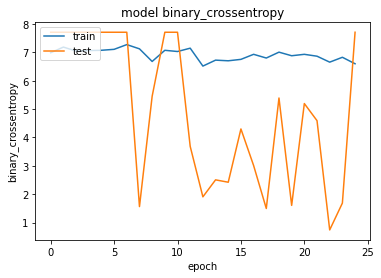

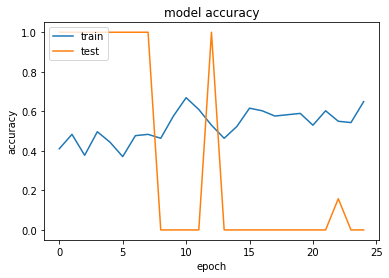

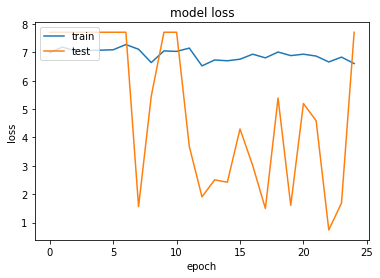

In [168]:
clear_all()
model = createModel(learning_rate=0.0001)


model = fit_model(model, 25, 2, class_weight, X, y)

In [75]:
# model.evaluate(X_test, y_test)

83/83 [==============================] - 0s 3ms/step - loss: 0.9903 - binary_crossentropy: 0.9859 - acc: 0.6426


[0.9902969598770142, 0.9859476089477539, 0.6426414847373962]

In [169]:
y_true = y_test
preds = model.predict(X_test)
y_pred = np.argmax(preds, axis=1)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99      2608
     class 1       0.00      0.00      0.00        42

    accuracy                           0.98      2650
   macro avg       0.49      0.50      0.50      2650
weighted avg       0.97      0.98      0.98      2650



Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [161]:
f1_score(y_true, y_pred)

0.0

In [128]:
# import shap

# # load your data here, e.g. X and y
# # create and fit your model here

# # load JS visualization code to notebook
# shap.initjs()

# # explain the model's predictions using SHAP
# # (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)

# # visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
# shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

# shap.summary_plot(shap_values, X, plot_type="bar")

Exception: Model type not yet supported by TreeExplainer: <class 'tensorflow.python.keras.engine.sequential.Sequential'>

In [132]:
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# import eli5
# from eli5.sklearn import PermutationImportance

# # def base_model():
# #     model = Sequential()        
# #     ...
# #     return model

# # X = ...
# # y = ...

# my_model = KerasClassifier(model)    
# my_model.fit(X_train,y_train)

# perm = PermutationImportance(my_model, random_state=1).fit(X_train,y_train)
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

AttributeError: 'KerasClassifier' object has no attribute 'classes_'

In [130]:
!pip install eli5

     |████████████████████████████████| 106 kB 883 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Try to use SMOTE to reduce imbalance

In [164]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# over = SMOTE(sampling_strategy=0.1)
# X, y = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy=0.5)
X, y = under.fit_resample(X_train, y_train)

## Find dependensies between the data

In [181]:
X_train.iloc[:, 10:20]

1_mean_place  1_mean_discharge  1_mean_route_type  \
0        -0.296448         -0.337384          -1.252140   
1        -0.296448         -0.337384          -1.252140   
2        -0.296448         -0.337384          -1.252140   
3        -0.296448         -0.337384          -1.252140   
4        -0.296448         -0.337384          -1.252140   
...            ...               ...                ...   
6111     -0.296448         -0.337384           1.068065   
6112     -0.296448         -0.337384           1.068065   
6113     -0.296448         -0.337384           1.068065   
6114     -0.296448         -0.337384           1.068065   
6115     -0.296448         -0.337384           1.068065   

      1_mean_snow_coverage_near_station  1_mean_snow_coverage_route  \
0                              -0.33743                   -1.231207   
1                              -0.33743                   -1.231207   
2                              -0.33743                   -1.231207   
3                              -0.33743                   -1.231207   
4                              -0.33743                   -1.231207   
...                                 ...                         ...   
6111                           -0.33743                    0.605226   
6112                           -0.33743                    0.605226   
6113                           -0.33743                    0.605226   
6114                           -0.33743                    0.605226   
6115                           -0.33743                    0.605226   

      1_mean_ice_crust_route  1_mean_snow_height_aver  1_mean_snow_height_max  \
0                        0.0                -1.035231               -1.042948   
1                        0.0                -1.035231               -1.042948   
2                        0.0                -1.035231               -1.042948   
3                        0.0                -1.035231               -1.042948   
4                        0.0                -1.035231               -1.042948   
...                      ...                      ...                     ...   
6111                     0.0                 0.733712                0.823259   
6112                     0.0                 0.733712                0.823259   
6113                     0.0                 0.733712                0.823259   
6114                     0.0                 0.733712                0.823259   
6115                     0.0                 0.733712                0.823259   

      1_mean_snow_height_min  1_mean_snow_density_aver  
0                  -1.011871                 -1.174037  
1                  -1.011871                 -1.174037  
2                  -1.011871                 -1.174037  
3                  -1.011871                 -1.174037  
4                  -1.011871                 -1.174037  
...                      ...                       ...  
6111                0.211863                  0.655113  
6112                0.211863                  0.655113  
6113                0.211863                  0.655113  
6114                0.211863                  0.655113  
6115                0.211863                  0.655113  

[6116 rows x 10 columns]

Text(0.5, 1.05, 'Pearson correlation of the features')

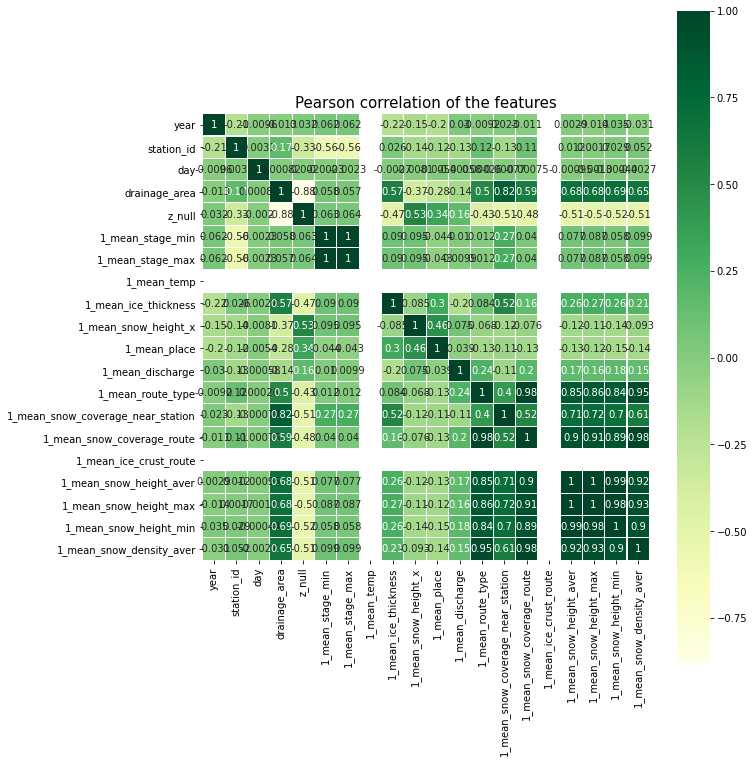

In [184]:
corr = X_train.iloc[:,:20].corr()

f, ax = plt.subplots(figsize=(10, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
_ = sns.heatmap(corr, cmap="YlGn", square=True, ax=ax, annot=True, linewidth=0.1)
plt.title('Pearson correlation of the features', y=1.05, size=15)

## Select features

In [185]:
X_train_2 = X_train[X_train.columns.drop(list(X_train.filter(regex='qual')))]

In [186]:
X_test_2 = X_test[X_test.columns.drop(list(X_test.filter(regex='qual')))]

In [188]:
X_train_2.shape, y_train.shape

((6116, 1400), (6116,))

In [190]:
def createModel2(learning_rate):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1400, ), dtype='int32'),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.15),
        tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    ])

    model.build(input_shape=(None, 1400))

    model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(lr=learning_rate), metrics=['binary_crossentropy', 'acc'])

    print(model.summary())
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                44832     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 45,954
Trainable params: 45,954
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
196/196 [==============================] - 1s 8ms/step - loss: 7.0931 - binary_crossentropy: 7.0938 - 

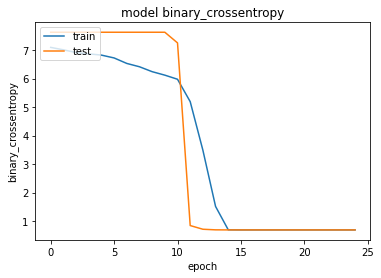

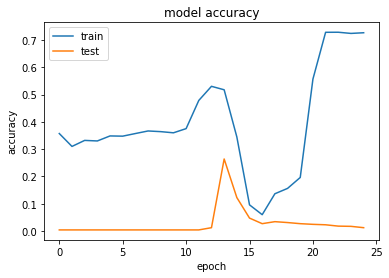

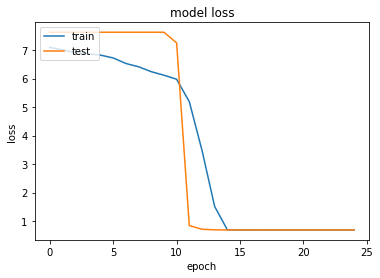

In [192]:
clear_all()
model = createModel2(learning_rate=0.0001)
model = fit_model(model, 25, 25, class_weight, X_train_2, y_train)

In [193]:
y_true = y_test
preds = model.predict(X_test_2)
y_pred = np.argmax(preds, axis=1)
target_names = ['class 0', 'class 1']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.03      0.07      2608
     class 1       0.02      1.00      0.03        42

    accuracy                           0.05      2650
   macro avg       0.51      0.52      0.05      2650
weighted avg       0.98      0.05      0.06      2650

